# PhyloBayes estimation of amino-acids preferences 

We test the estimation of amino-acids preferences with PhyloBayes.
    1. Download newick tree and site-specific amino-acid preferences generated by deep mutational scanning in the lab 
    2. Use the data to run simulations with SimuEvol, thus obtaining alignment.
    3. Estimate site-specific amino-acid preferences with PhyloBayes using the alignment.
    4. Compate the estimation to the original site-specific amino-acid preferences 

Requirements: 

Dataset: [Bloom 2017](https://biologydirect.biomedcentral.com/articles/10.1186/s13062-016-0172-z)

SimuEvol: https://github.com/ThibaultLatrille/SimuEvol

PhyloBayes MPI: https://github.com/bayesiancook/pbmpi2

DMS_tools: https://jbloomlab.github.io/dms_tools/index.html
    
## global imports,  input and output path


In [1]:
# GLOBAL IMPORTS
from IPython.display import display
from wand.image import Image as WImage

current_dir = "/home/thibault/SimuEvol"
protein = "np"
exp = "_p0.01"

prefs_path = "{0}/data/{1}.txt".format(current_dir, protein)
newick_path = "{0}/data/{1}.newick".format(current_dir, protein)

simu_evol_path = "{0}/cmake-build-debug/SimuEvol".format(current_dir)

ali_path = "{0}/data/{1}{2}.ali".format(current_dir, protein, exp)
pb_data_path = "{0}/data/pb_{1}{2}".format(current_dir, protein, exp)

## Plot of the initial amino-acid preferences


Here is the selection plot /home/thibault/SimuEvol/data/np.pdf


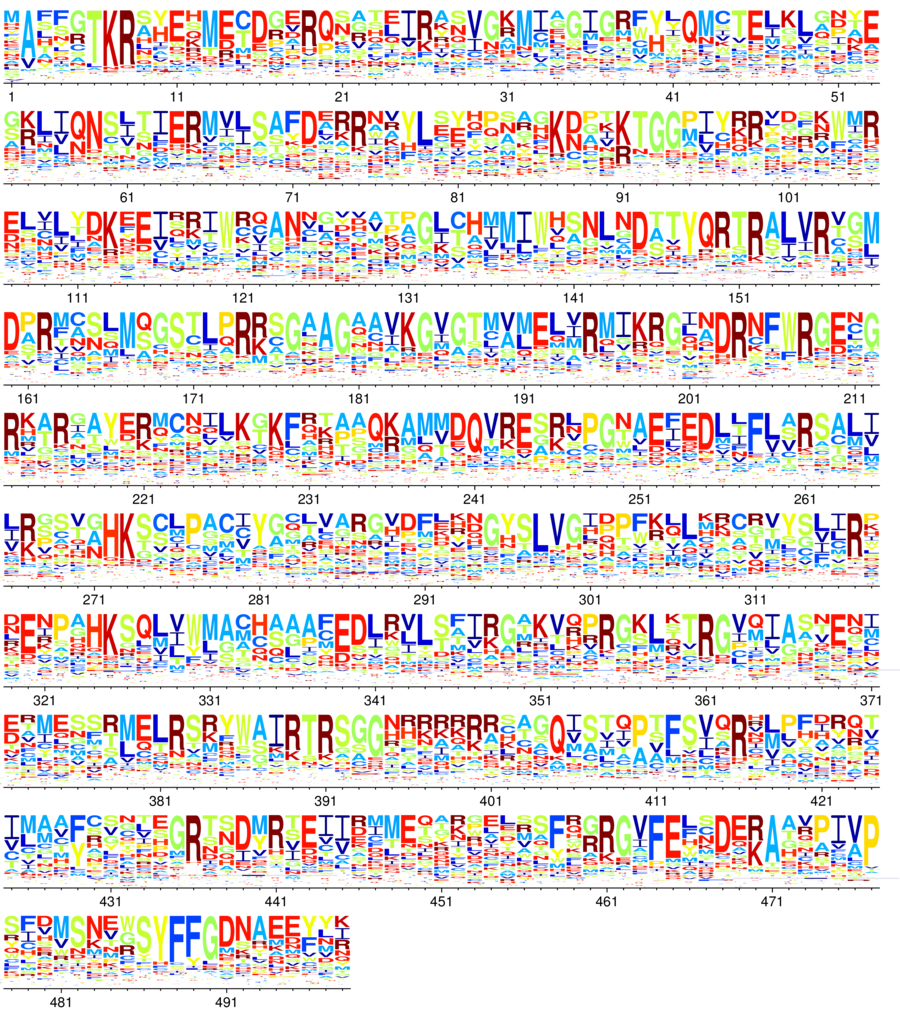

In [2]:
pdf_path = "{0}/data/{1}.pdf".format(current_dir, protein)

nperline = 53
log = !dms_logoplot {prefs_path} {pdf_path} --nperline {nperline}

def plot(plot_name, size='900x'):
    print("Here is the selection plot {0}".format(plot_name))
    img = WImage(filename=plot_name, resolution=480)
    img.transform(resize=size)
    display(img)
    
plot(pdf_path)

## Forward simulation in C++

Producing a alignment in .ali format from a preferences file and a newick tree.

In [3]:
!{simu_evol_path} --preferences={prefs_path} --newick={newick_path} --output={ali_path} --mu=1.5 --lambda=3 --p=0.01

The tree contains 359 nodes for 180 species at the tips.
The tree has a total branch length of 2.49728.
The DNA sequence is 1494 base pairs long.
The simulation mapped 23254 substitutions along the tree.
6815 synonymous and 16439 non-synonymous substitutions.


## Preferences estimation with PhyloBayes

In [4]:
nbr_cpu = 6
points = 400

!mpirun -n {nbr_cpu} pb_mpi -f -s -x 1 {points} -mutsel -freeomega -dp -d {ali_path} -T {newick_path} {pb_data_path}


model:
stick-breaking Dirichlet process mixture (cat)
codon mutation selection model


chain name : /home/thibault/SimuEvol/data/pb_np_p0.01
run started

#iter	time	pruning	lnL	length	codonent	omega	Nmode	statent	statalpha	nucsA	nucsC	nucsG	nucsT	nucrrAC	nucrrAG	nucrrAT	nucrrCG	nucrrCT	nucrrGT
0	0	0	-132831	38.3395	4.11087	1	5	2.58064	20	0.207922	0.260893	0.292483	0.238702	0.363649	0.0438991	0.0633951	0.0321512	0.0926091	0.404297

current logL : -132831	-132831
/home/thibault/SimuEvol/data/pb_np_p0.01: stopping after 400 points.
current logL : -93443.7	-93443.7


In [5]:
burn_in = 150
!readpb_mpi -x {burn_in} -om {pb_data_path}
!readpb_mpi -x {burn_in} -ss {pb_data_path}

burnin : 150
until : 400
..........................................................................................................................................................................................................................................................
mean site-specific predicted dN/dS in/home/thibault/SimuEvol/data/pb_np_p0.01.predsiteomega
global mean predicted omega: 0.746926

burnin : 150
until : 400
..........................................................................................................................................................................................................................................................
mean site-specific profiles in /home/thibault/SimuEvol/data/pb_np_p0.01.siteprofiles



## Plot estimated amino-acid preferences

Here is the selection plot /home/thibault/SimuEvol/data/pb_np_p0.01_prefs.pdf


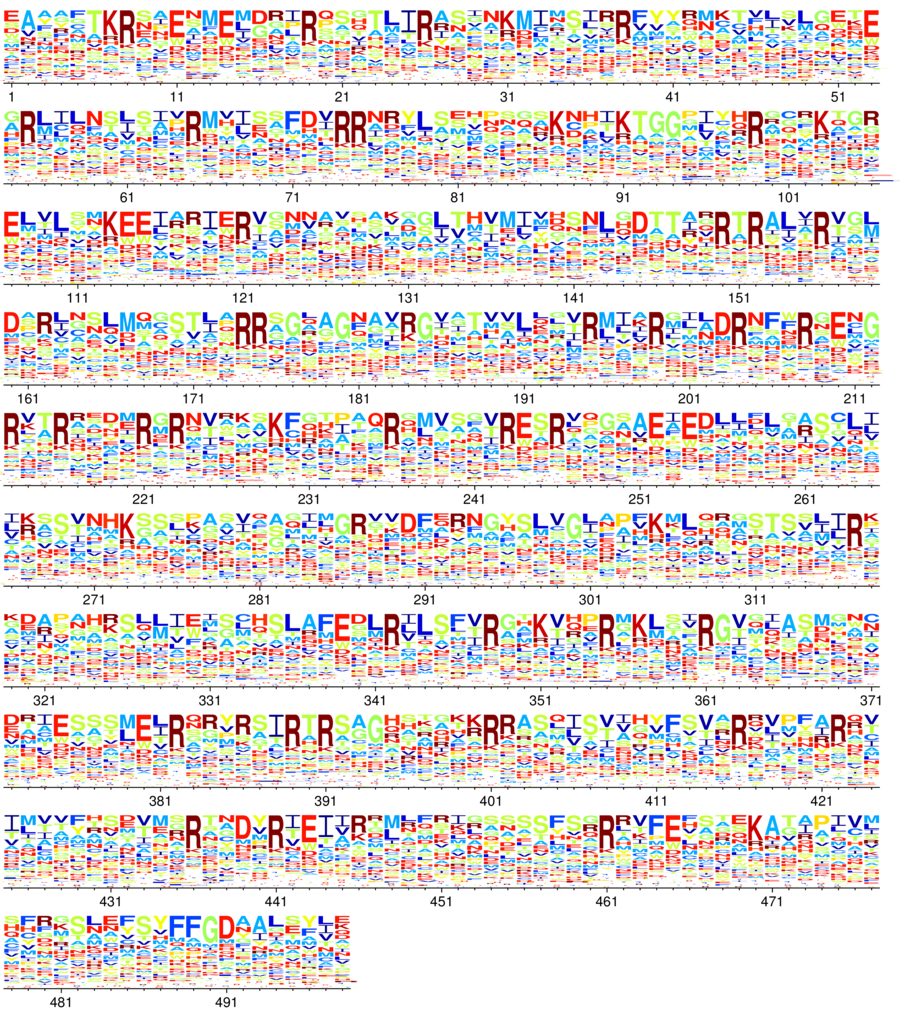

In [6]:
pb_siteprofiles = '{0}.siteprofiles'.format(pb_data_path)
pb_prefs = '{0}_prefs.txt'.format(pb_data_path)

with open(pb_siteprofiles, 'r') as r:
    with open(pb_prefs, 'w') as w:
        r.readline()
        w.write("# POSITION WT SITE_ENTROPY PI_A PI_C PI_D PI_E PI_F PI_G PI_H PI_I PI_K PI_L PI_M PI_N PI_P PI_Q PI_R PI_S PI_T PI_V PI_W PI_Y\n")
        for line in r:
            line_split = line.replace('\n', '').split('\t')
            w.write(line_split[0] + " A 1.0 " + " ".join(line_split[1:]) + "\n")

prefsplot = '{0}_prefs.pdf'.format(pb_data_path)

log = !dms_logoplot {pb_prefs} {prefsplot} --nperline {nperline}

plot(prefsplot)

Here is the selection plot /home/thibault/SimuEvol/data/pb_np_p0.01_diff.pdf


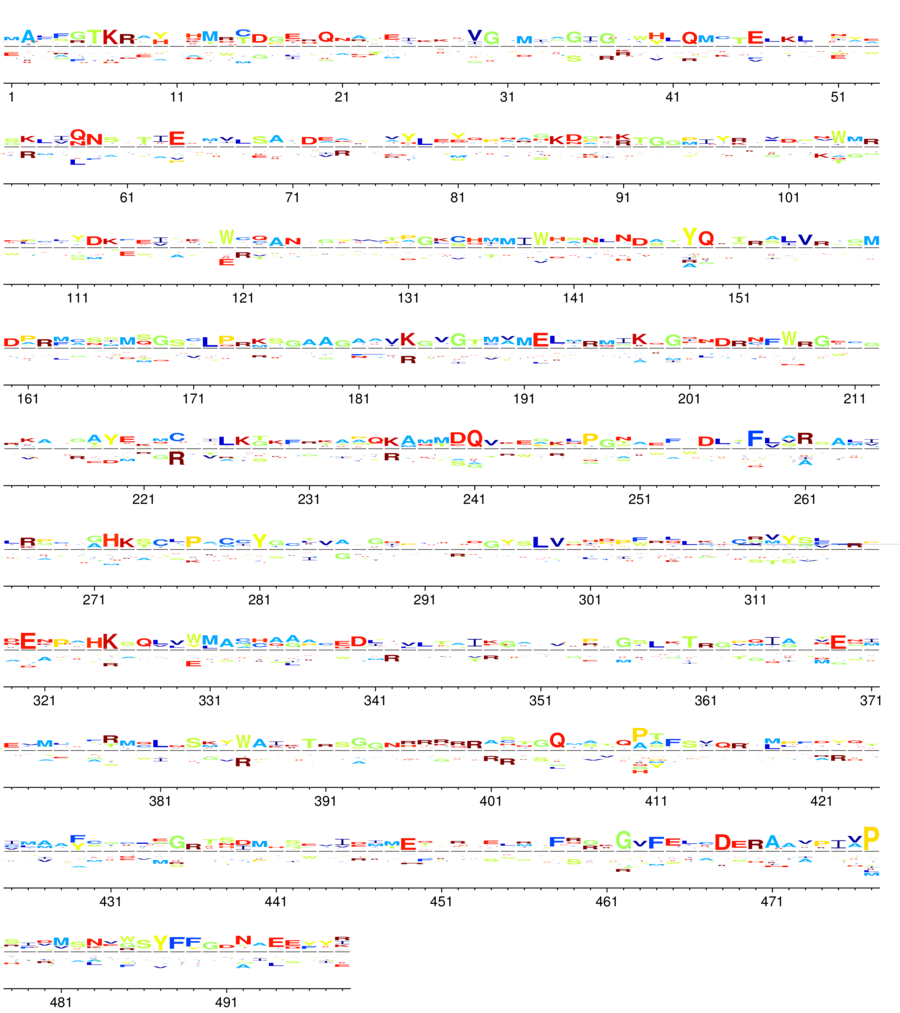

Here is the selection plot /home/thibault/SimuEvol/data/pb_np_p0.01_diff_corr.pdf


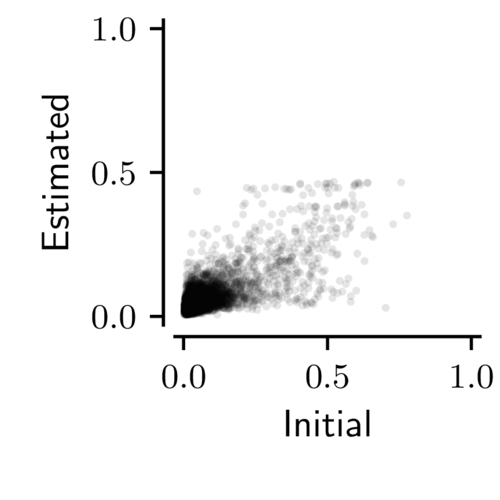

R = 0.749741
P = 0
N = 9960

In [7]:
diff_prefs = "{0}_diff".format(pb_data_path)

log = !dms_merge {diff_prefs} sum {prefs_path} --minus {pb_prefs}

diff_plot = '{0}.pdf'.format(diff_prefs)
log = !dms_logoplot {diff_prefs} {diff_plot} --nperline {nperline}

plot(diff_plot)

corr_plot = '{0}_corr'.format(diff_prefs)
log = !dms_correlate {prefs_path} {pb_prefs} {corr_plot} --name1 "Initial" --name2 "Estimated"

plot('{0}.pdf'.format(corr_plot), size='500x')
!cat {corr_plot}.txt